<a href="https://colab.research.google.com/github/aliakbarbadri/natural-language-inference/blob/master/seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import tensorflow_addons as tfa

import unicodedata
import re
import numpy as np
import os
import io
import time
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

# Load and Preprocess the data

In [80]:
source = pd.read_pickle(r'https://github.com/aliakbarbadri/natural-language-inference/blob/master/premises_train.pickle?raw=true')
target = pd.read_pickle(r'https://github.com/aliakbarbadri/natural-language-inference/blob/master/hypotheses_train.pickle?raw=true')

In [81]:
print(source[0])
print(target[0])

A person on a horse jumps over a broken down airplane .
A person is outdoors , on a horse .


In [82]:
lines_main = pd.DataFrame(
    {'source': source,
     'target': target
     })

In [83]:
lines_main.shape

(183416, 2)

In [84]:
lines = lines_main[:50000]

In [85]:
lines.shape

(50000, 2)

In [86]:
# Lowercase all characters
lines.source=lines.source.apply(lambda x: x.lower())
lines.target=lines.target.apply(lambda x: x.lower())

# Remove quotes
lines.source=lines.source.apply(lambda x: re.sub("'", '', x))
lines.target=lines.target.apply(lambda x: re.sub("'", '', x))

exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines.source=lines.source.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.target=lines.target.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines.source=lines.source.apply(lambda x: x.translate(remove_digits))
lines.target=lines.target.apply(lambda x: x.translate(remove_digits))

# Remove extra spaces
lines.source=lines.source.apply(lambda x: x.strip())
lines.target=lines.target.apply(lambda x: x.strip())
lines.source=lines.source.apply(lambda x: re.sub(" +", " ", x))
lines.target=lines.target.apply(lambda x: re.sub(" +", " ", x))

# Add start and end tokens to target sequences
lines.target = lines.target.apply(lambda x : 'START_ '+ x + ' _END')

lines.sample(10)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,source,target
17154,a man wearing colorful clothing and white sung...,START_ he man makes music _END
16693,a man in a wetsuit is surfing up and over a wave,START_ a man is surfing over a wave _END
28402,a groomsman at a wedding is showing off hulaho...,START_ someone is hula hooping _END
7817,a shorthaired man in sitting on a curb eating ...,START_ a man is eating outside _END
21986,a man in the winter standing on shoveled snow ...,START_ a man in the winter standing on a path ...
35152,a street with people riding bikes around big b...,START_ people are riding bikes on the street _END
12310,a woman in a purple sweater stands with her ar...,START_ there are multiple people present _END
47578,a group of young girls in ethnic orange costum...,START_ group of young girls perform a dance on...
41411,two young asian children are playing on playgr...,START_ children are playing _END
32241,a large group at a concert or fair all looking...,START_ a group of people look at a man in whit...


In [87]:
all_words_source=set()
for line in lines.source:
    for word in line.split():
        if word not in all_words_source:
            all_words_source.add(word)

all_words_target=set()
for line in lines.target:
    for word in line.split():
        if word not in all_words_target:
            all_words_target.add(word)

In [88]:
lenght_list=[]
for l in lines.source:
    lenght_list.append(len(l.split(' ')))
max_length_src = np.max(lenght_list)

lenght_list=[]
for l in lines.target:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)

max_length_src, max_length_tar

(78, 45)

In [89]:
input_words = sorted(list(all_words_source))
target_words = sorted(list(all_words_target))

num_encoder_tokens = len(all_words_source)
num_decoder_tokens = len(all_words_target)

num_encoder_tokens, num_decoder_tokens

(11410, 8693)

In [90]:
num_encoder_tokens += 1 
num_decoder_tokens += 1 # For zero padding
num_encoder_tokens, num_decoder_tokens

(11411, 8694)

In [91]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [92]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [93]:
# lines = shuffle(lines)
lines.head(10)

,source,target
0,a person on a horse jumps over a broken down a...,START_ a person is outdoors on a horse _END
1,children smiling and waving at camera,START_ there are children present _END
2,a boy is jumping on skateboard in the middle o...,START_ the boy does a skateboarding trick _END
3,two blond women are hugging one another,START_ there are women showing affection _END
4,a few people in a restaurant setting one of th...,START_ the diners are at a restaurant _END
5,an older man is drinking orange juice at a res...,START_ a man is drinking juice _END
6,a man with blondhair and a brown shirt drinkin...,START_ a blond man drinking water from a fount...
7,two women who just had lunch hugging and sayin...,START_ there are two woman in this picture _END
8,two women holding food carryout containers hug,START_ two women hug each other _END
9,a little league team tries to catch a runner s...,START_ a team is trying to tag a runner out _END


In [94]:
# Train - Test Split
X, y = lines.source, lines.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train.shape, X_test.shape

((40000,), (10000,))

In [95]:
# X_train.to_pickle('X_train.pkl')
# X_test.to_pickle('X_test.pkl')

In [96]:
def generate_batch(X = X_train, y = y_train, batch_size = 64):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

# Model

In [97]:
latent_dim = 256

In [98]:
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(1024, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

In [99]:
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)(decoder_inputs)
decoder_lstm = LSTM(1024, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [100]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, None, 256)    2921216     input_11[0][0]                   
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, None, 256)    2225664     input_12[0][0]                   
____________________________________________________________________________________________

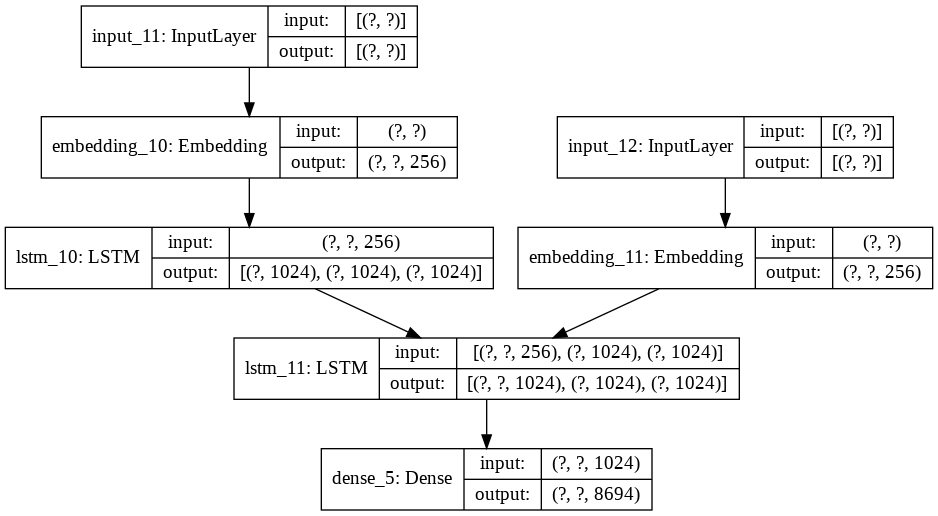

In [101]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [102]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 32
epochs = 10

In [103]:
history = model.fit(generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

Epoch 1/10
1250/1250 [==============================] - 239s 191ms/step - loss: 0.6325 - acc: 0.0645 - val_loss: 0.5715 - val_acc: 0.0719
Epoch 2/10
1250/1250 [==============================] - 237s 189ms/step - loss: 0.5440 - acc: 0.0743 - val_loss: 0.5401 - val_acc: 0.0756
Epoch 3/10
 345/1250 [=======>......................] - ETA: 2:36 - loss: 0.5146 - acc: 0.0770

KeyboardInterrupt: ignored

In [ ]:
# model = keras.models.load_model('seq2seq_model.h5')

In [ ]:
# model.save('seq2seq_model.h5')

# Loss and Acc. graph

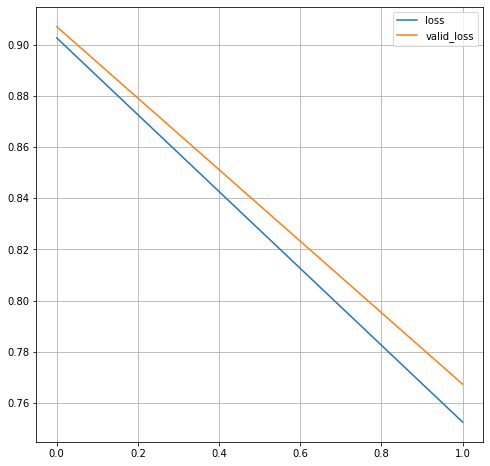

In [ ]:
pd.DataFrame({'loss':history.history['loss'],
              'valid_loss':history.history['val_loss'],
              }).plot(figsize=(8, 8))
plt.grid(True)

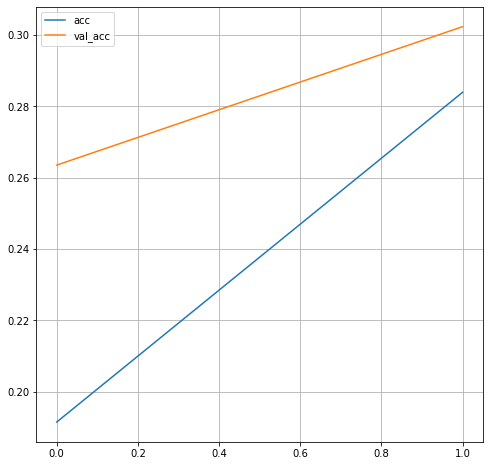

In [ ]:
pd.DataFrame({'acc':history.history['acc'],
              'val_acc':history.history['val_acc']
              }).plot(figsize=(8, 8))
plt.grid(True)


# Model Evaluation

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs2] + decoder_states2)

In [ ]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_token_index['START_']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]
    return decoded_sentence

In [ ]:
test_gen = generate_batch(X_test, y_test, batch_size = 1)
k=-1

In [ ]:
for k in range(X_test.shape[0])
k+=1
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input:', X_test[k:k+1].values[0])
print('Actual:', y_test[k:k+1].values[0][6:-4])
print('Predicted:', decoded_sentence[:-4])

Input: a man is getting help with fitness
Actual:  a man getting help with fitness from a physical trainer in a gym 
Predicted:  a man in a white shirt is working on a stage 


In [ ]:
# just to see why use 6, -4
print(y_test[k:k+1].values[0]))
print(y_test[k:k+1].values[0][6:-4])
print()
print(decoded_sentence)
print(decoded_sentence[:-4])

START_ a man getting help with fitness from a physical trainer in a gym _END
 a man getting help with fitness from a physical trainer in a gym 

 a man in a white shirt is working on a stage _END
 a man in a white shirt is working on a stage 


# Blue

In [ ]:
list_of_references = []
list_of_hypotheses = []
for k in range(val_samples)
  (input_seq, actual_output), _ = next(test_gen)
  decoded_sentence = decode_sequence(input_seq)

  list_of_hypotheses.append(y_test[k:k+1].values[0][6:-4].split())
  list_of_references.append([decoded_sentence[:-4].split()])
  print('Input:', X_test[k:k+1].values[0])
  print('Actual:', y_test[k:k+1].values[0][6:-4])
  print('Predicted:', decoded_sentence[:-4])


https://towardsdatascience.com/evaluating-text-output-in-nlp-bleu-at-your-own-risk-e8609665a213

In [ ]:
list_of_references = [[ref1a, ref1b, ref1c], [ref2a]]
>>> hypotheses = [hyp1, hyp2]
>>> corpus_bleu(list_of_references, hypotheses) 
0.5920...

# first 30 of test 

In [ ]:
for i in range(30):
  print(i)
  print(list_of_references[i][0])
  print(list_of_hypotheses[i])
  print("---------------------")